<IPython.core.display.Javascript object>


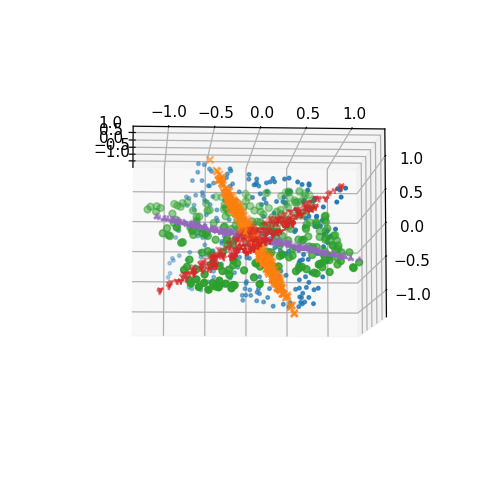

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mlcv import generate_points

np.random.seed(1)

def render_pcl(data, indexing, ax=None):
    _indexing = np.zeros(indexing.shape, dtype=np.int)
    index_mapping, index_ctr = {}, 0
    for vertex, index in enumerate(indexing):
        if index not in index_mapping:
            index_mapping[index] = index_ctr
            index_ctr += 1
        _indexing[vertex] = index_mapping[index]
    if ax is None:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, projection='3d')
    markers = [".","x","o","1","2","3","4"]
    for part_idx in range(index_ctr+1):
        samples = data[_indexing == part_idx]
        ax.scatter(samples[:,0], 
                   samples[:,1], 
                   samples[:,2], 
                   marker=markers[part_idx%len(markers)])

        
def render_stats(stats, axes=None):
    if axes is None:
        fig,axes = plt.subplots(5,1,figsize=(6,12))
    ax1,ax2,ax3,ax4,ax5 = axes
    iters = np.arange(len(stats))
    ax1.plot(iters, [st["rc"] for st in stats], label="reduced costs")
    ax2.plot(iters, [st["t_neighbours"] for st in stats], label="time/neighbourhood-generation" )
    ax3.plot(iters, [st["t_rcs"]["mean"] for st in stats], label="average time/reduced-costs-computation")
    ax3.fill_between(iters, 
                     [st["t_rcs"]["mean"]-st["t_rcs"]["std"]*0.5 for st in stats], 
                     [st["t_rcs"]["mean"]+st["t_rcs"]["std"]*0.5 for st in stats],  
                     color='grey', alpha=0.2)
    ax4.bar(iters, [st["t_neighbours"] for st in stats], width=1, label="time/neighbourhood-generation")
    ax4.bar(iters, [st["t_rcs"]["sum"] for st in stats], width=1, bottom=[st["t_neighbours"] for st in stats],
            label="time/reduced-costs-computation")
    ax5.plot(iters, [st["partcount"] for st in stats], label="partitions")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("costs")
    ax1.legend()
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("time [ms]")
    ax2.legend()
    ax3.set_xlabel("iteration")
    ax3.set_ylabel("time [ms]")
    ax3.legend()
    ax4.set_xlabel("iteration")
    ax4.set_ylabel("time [ms]")
    ax4.legend()
    ax5.set_xlabel("iteration")
    ax5.set_ylabel("#partitions")
    ax5.legend()
        
data,ground_truth = generate_points([0.01,0.01,0.01,0.01,0.01],
                                    [250,250,250,250,250])
render_pcl(data,ground_truth)

<IPython.core.display.Javascript object>


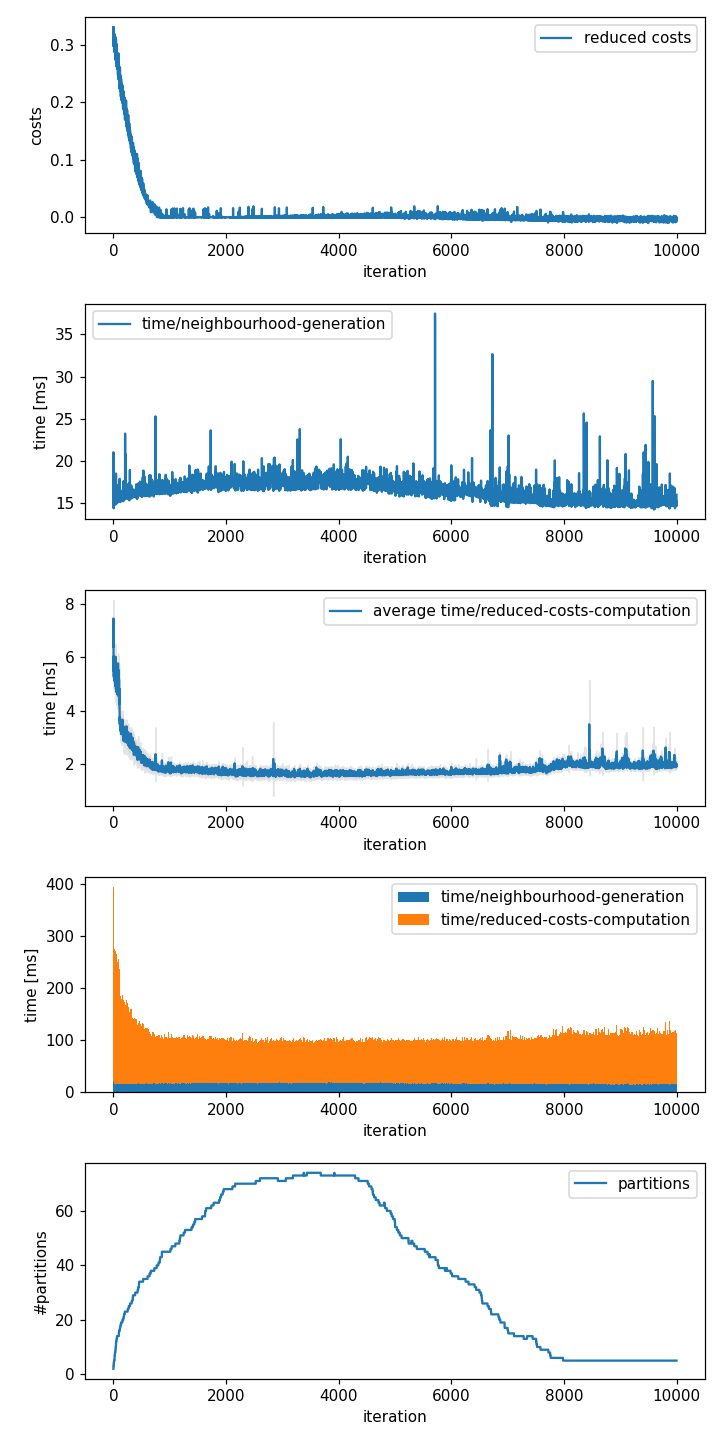

In [2]:
from mlcv import distance_to_origin, cost, reduced_cost, greedy_search, taboo_search, compute_index_counts
from time import time
from tqdm.notebook import trange, tqdm

def cf_prime(data,combs):
    dthr = 0.1
    # return distance_to_origin(data,combs) - dthr
    return distance_to_origin(data,combs) + np.sqrt( distance_to_origin(data,combs) ) - np.sqrt( dthr ) - dthr

def cf(data,combs):
    return np.zeros(combs.shape)

# indexing = np.zeros(data.shape[0], dtype=np.int)
indexing = np.random.choice(1,data.shape[0])

stop, stats = 10000, []
# alg = taboo_search(data, indexing, cf, cf_prime, taboo_dur=30, stop=stop, N=20, M=10000)
alg = greedy_search(data, indexing, None, cf_prime, stop=stop, N=50, M=10000)
current_indexing = None
pbar = tqdm(alg, total=stop)
for indexing, v, k, stats_bm in pbar:
    current_indexing = indexing
    counts = compute_index_counts(indexing)
    partcount = np.sum(counts!=0)
    stats_bm = { **stats_bm, "partcount": partcount}
    stats.append(stats_bm)
    pbar.set_description("partitions %03d" % partcount)
    
render_stats(stats)
plt.tight_layout()

<IPython.core.display.Javascript object>


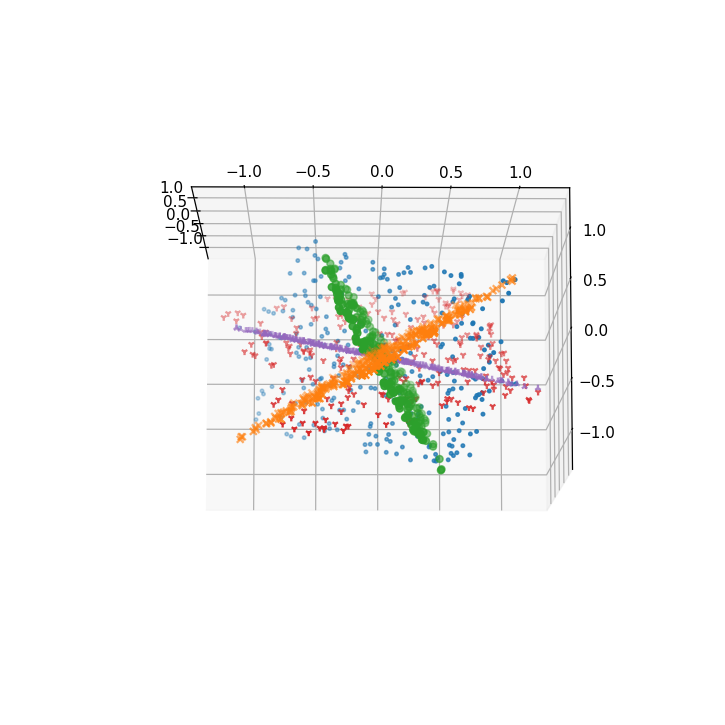

In [3]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
render_pcl(data, current_indexing, ax=ax)

<IPython.core.display.Javascript object>


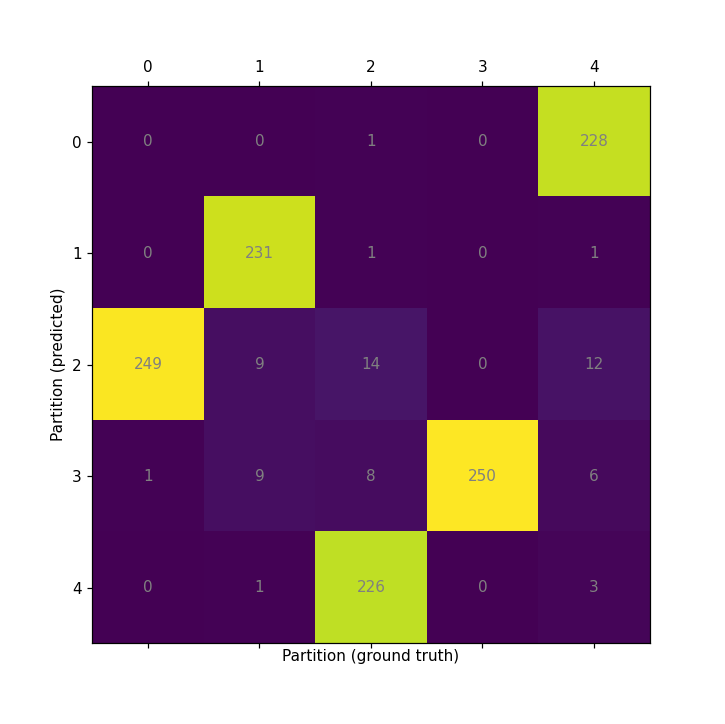

Text(0, 0.5, 'Partition (predicted)')

In [4]:

x_gt = np.unique(ground_truth)
x_pred = np.unique(current_indexing)
overlap_mat = np.zeros((x_pred.shape[0], x_gt.shape[0]))
for idx_gt, part_gt in enumerate(x_gt):
    overlap = current_indexing[ ground_truth == part_gt ]
    for idx_pred, part_pred in enumerate(x_pred):
        overlap_idx = np.sum(overlap == part_pred)
        overlap_mat[ idx_pred, idx_gt ] = overlap_idx

fig, ax = plt.subplots(figsize=(6,6))
ax.matshow(overlap_mat)
for (i, j), z in np.ndenumerate(overlap_mat):
    ax.text(j, i, "%d" % z, ha='center', va='center', color="grey")
ax.set_xlabel("Partition (ground truth)")
ax.set_ylabel("Partition (predicted)")